In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, transforms, models
import os
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(7, shear=15, scale=(0.5, 1.7)),
    transforms.ColorJitter(brightness=0.7, contrast=0.4, saturation=0.6),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

training_dataset = datasets.ImageFolder('train', transform=transform_train)
validation_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [4]:
def im_convert(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    return image

In [5]:
classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

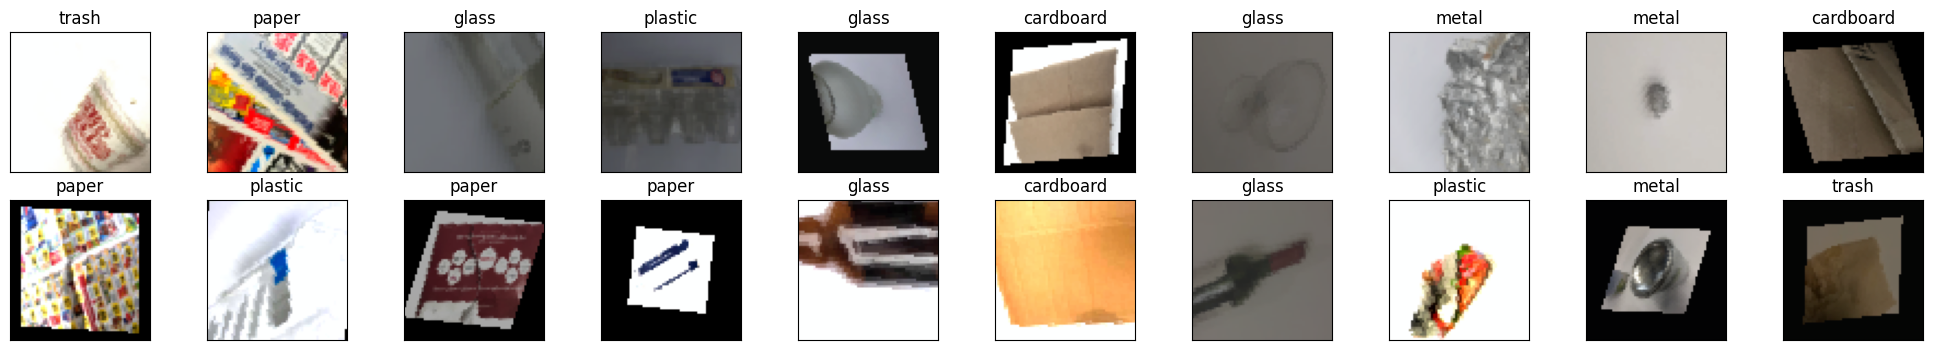

In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.__next__()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

# ChromaNet

In [7]:
class ChromaNet(nn.Module):
    def __init__(self):
        super(ChromaNet, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.relu6 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.relu7 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.relu8 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 6)

    def forward(self, x):
        # Convolutional Block 1
        x = self.pool1(self.relu2(self.bn2(self.conv2(self.relu1(self.bn1(self.conv1(x)))))))
        
        # Convolutional Block 2
        x = self.pool2(self.relu4(self.bn4(self.conv4(self.relu3(self.bn3(self.conv3(x)))))))
        
        # Convolutional Block 3
        x = self.pool3(self.relu6(self.bn6(self.conv6(self.relu5(self.bn5(self.conv5(x)))))))
        
        # Flatten
        x = x.view(-1, 256 * 8 * 8)
        
        # Fully Connected Layers
        x = self.dropout1(self.relu7(self.fc1(x)))
        x = self.dropout2(self.relu8(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [8]:
# Instantiate the model
model = ChromaNet()

In [9]:
# Move the model to the GPU if available
model.to(device)

ChromaNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [10]:
# Print the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')

Total parameters: 18453318


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [12]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    start_time = time.time()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
    
    end_time = time.time()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_preds.double() / len(train_loader.dataset)
    epoch_time = end_time - start_time
    return epoch_loss, epoch_acc, epoch_time

In [13]:
def validate(model, criterion, val_loader, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
    
    end_time = time.time()
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct_preds.double() / len(val_loader.dataset)
    epoch_time = end_time - start_time
    return epoch_loss, epoch_acc, epoch_time

In [14]:
# Define lists to store loss and accuracy values for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_times = []
val_times = []
best_val_acc = 0.0

# Train and validate the model
num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_acc, train_time = train(model, criterion, optimizer, training_loader, device)
    val_loss, val_acc, val_time = validate(model, criterion, validation_loader, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_times.append(train_time)
    val_times.append(val_time)
    
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, "
          f"Train Time: {train_time:.2f}s, Validation Time: {val_time:.2f}s")

Epoch 1/50: Train Loss: 2.5164, Train Accuracy: 0.2127, Validation Loss: 1.6624, Validation Accuracy: 0.2675, Train Time: 37.75s, Validation Time: 9.04s
Epoch 2/50: Train Loss: 1.7859, Train Accuracy: 0.2229, Validation Loss: 1.6526, Validation Accuracy: 0.2964, Train Time: 26.30s, Validation Time: 4.79s
Epoch 3/50: Train Loss: 1.7643, Train Accuracy: 0.2336, Validation Loss: 1.6567, Validation Accuracy: 0.3057, Train Time: 26.05s, Validation Time: 4.74s
Epoch 4/50: Train Loss: 1.7076, Train Accuracy: 0.2319, Validation Loss: 1.6347, Validation Accuracy: 0.2885, Train Time: 26.21s, Validation Time: 4.71s
Epoch 5/50: Train Loss: 1.6930, Train Accuracy: 0.2698, Validation Loss: 1.6576, Validation Accuracy: 0.3254, Train Time: 26.33s, Validation Time: 4.75s
Epoch 6/50: Train Loss: 1.6952, Train Accuracy: 0.2511, Validation Loss: 1.6054, Validation Accuracy: 0.2767, Train Time: 26.22s, Validation Time: 4.81s
Epoch 7/50: Train Loss: 1.6758, Train Accuracy: 0.2805, Validation Loss: 1.6230, V

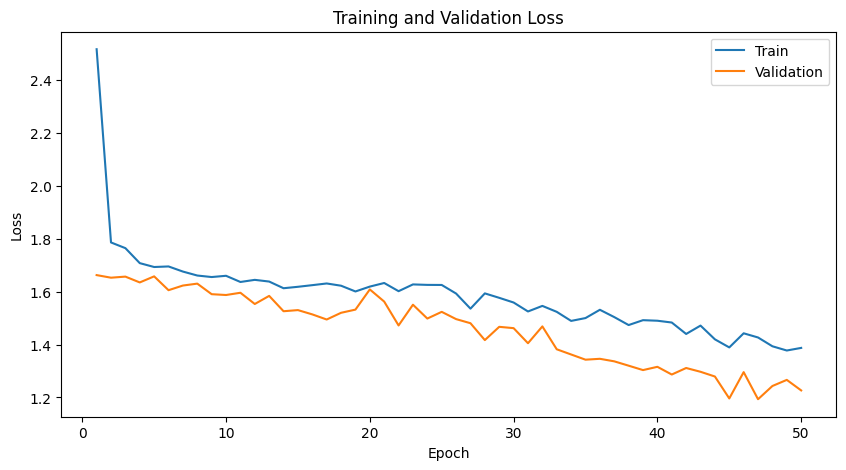

In [15]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

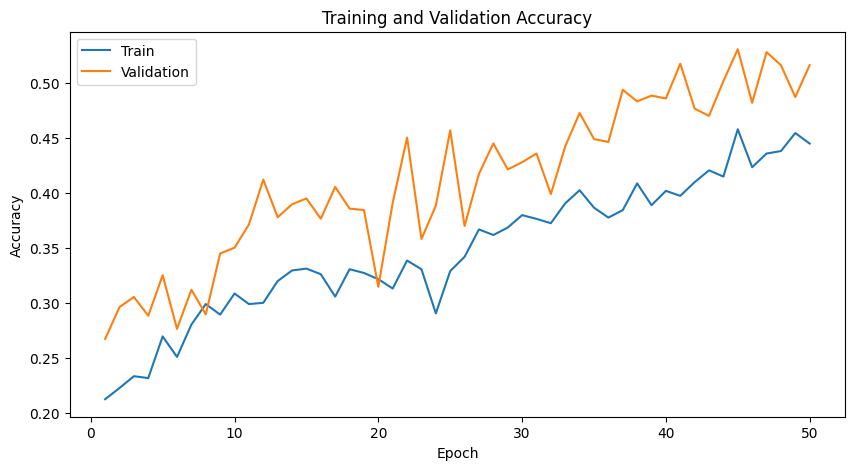

In [16]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in train_accuracies], label='Train')
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in val_accuracies], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

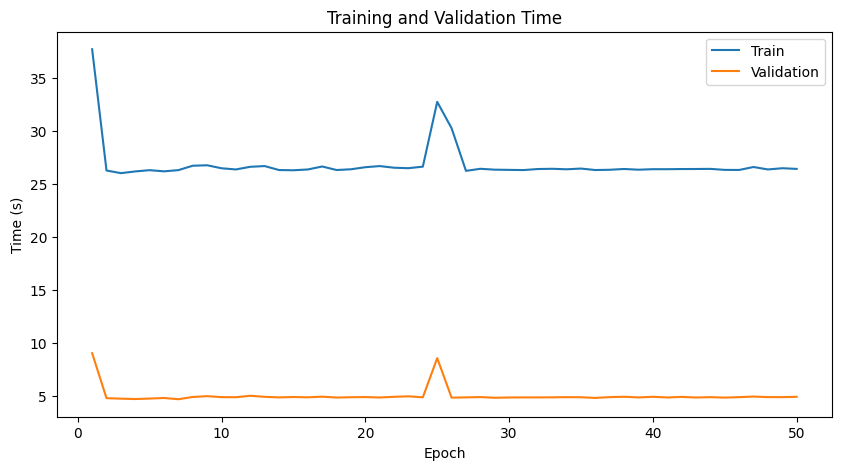

In [17]:
# Plot training and validation times
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_times, label='Train')
plt.plot(range(1, num_epochs + 1), val_times, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Training and Validation Time')
plt.legend()
plt.show()

# VGG-19

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

training_dataset = datasets.ImageFolder('train', transform=transform_train)
validation_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [5]:
def im_convert(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    return image

In [6]:
classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

In [7]:
model = models.vgg19(pretrained=True)

D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
for param in model.features.parameters():
  param.requires_grad = False

In [9]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

6


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)

In [11]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    start_time = time.time()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
    
    end_time = time.time()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_preds.double() / len(train_loader.dataset)
    epoch_time = end_time - start_time
    return epoch_loss, epoch_acc, epoch_time

In [12]:
def validate(model, criterion, val_loader, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
    
    end_time = time.time()
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct_preds.double() / len(val_loader.dataset)
    epoch_time = end_time - start_time
    return epoch_loss, epoch_acc, epoch_time

In [13]:
# Define lists to store loss and accuracy values for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_times = []
val_times = []
best_val_acc = 0.0

# Train and validate the model
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc, train_time = train(model, criterion, optimizer, training_loader, device)
    val_loss, val_acc, val_time = validate(model, criterion, validation_loader, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_times.append(train_time)
    val_times.append(val_time)
    
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, "
          f"Train Time: {train_time:.2f}s, Validation Time: {val_time:.2f}s")

Epoch 1/30: Train Loss: 1.5861, Train Accuracy: 0.3626, Validation Loss: 1.3069, Validation Accuracy: 0.6153, Train Time: 169.72s, Validation Time: 59.06s
Epoch 2/30: Train Loss: 1.2170, Train Accuracy: 0.5628, Validation Loss: 1.0189, Validation Accuracy: 0.7009, Train Time: 155.83s, Validation Time: 54.40s
Epoch 3/30: Train Loss: 0.9896, Train Accuracy: 0.6437, Validation Loss: 0.8419, Validation Accuracy: 0.7273, Train Time: 155.47s, Validation Time: 54.13s
Epoch 4/30: Train Loss: 0.8590, Train Accuracy: 0.6917, Validation Loss: 0.7489, Validation Accuracy: 0.7404, Train Time: 155.64s, Validation Time: 54.30s
Epoch 5/30: Train Loss: 0.7865, Train Accuracy: 0.7189, Validation Loss: 0.6704, Validation Accuracy: 0.7470, Train Time: 155.80s, Validation Time: 54.17s
Epoch 6/30: Train Loss: 0.7001, Train Accuracy: 0.7460, Validation Loss: 0.6290, Validation Accuracy: 0.7694, Train Time: 155.53s, Validation Time: 54.13s
Epoch 7/30: Train Loss: 0.6790, Train Accuracy: 0.7523, Validation Los

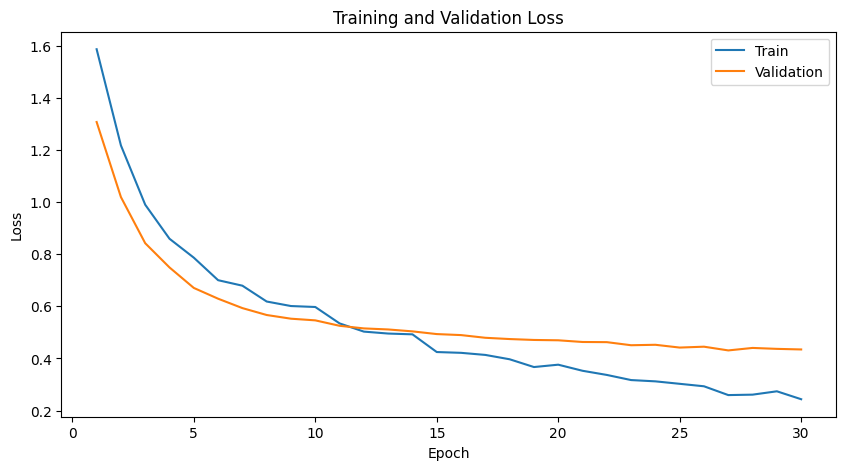

In [14]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

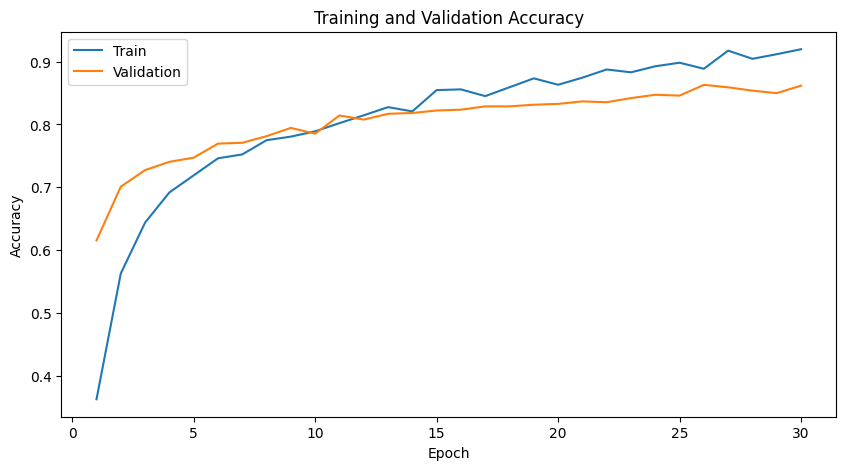

In [15]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in train_accuracies], label='Train')
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in val_accuracies], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

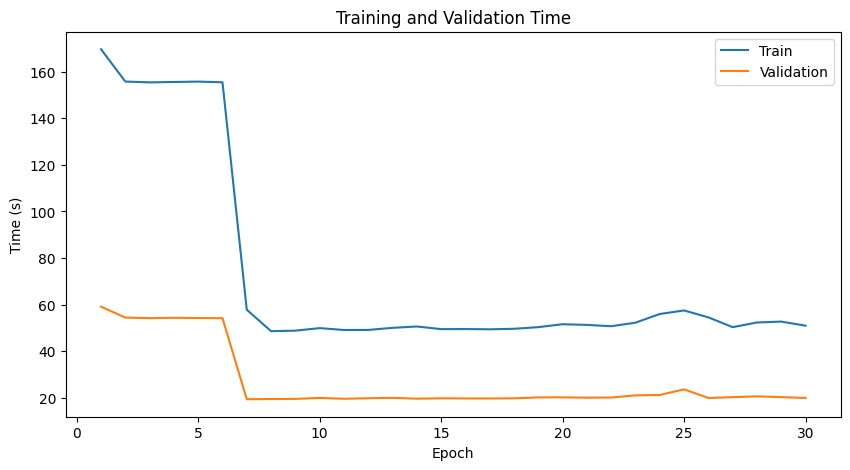

In [16]:
# Plot training and validation times
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_times, label='Train')
plt.plot(range(1, num_epochs + 1), val_times, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Training and Validation Time')
plt.legend()
plt.show()

# ResNet50

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

training_dataset = datasets.ImageFolder('train', transform=transform_train)
validation_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [5]:
def im_convert(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    return image

In [6]:
classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

In [7]:
# Load the pre-trained ResNet model
model = models.resnet50(pretrained=True)

D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Modify the last fully connected layer to have an output size of 6
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 6)

In [9]:
# Move the model to the GPU
model = model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [11]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    start_time = time.time()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
    
    end_time = time.time()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_preds.double() / len(train_loader.dataset)
    epoch_time = end_time - start_time
    return epoch_loss, epoch_acc, epoch_time

In [12]:
def validate(model, criterion, val_loader, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
    
    end_time = time.time()
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct_preds.double() / len(val_loader.dataset)
    epoch_time = end_time - start_time
    return epoch_loss, epoch_acc, epoch_time

In [13]:
# Define lists to store loss and accuracy values for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_times = []
val_times = []
best_val_acc = 0.0

# Train and validate the model
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc, train_time = train(model, criterion, optimizer, training_loader, device)
    val_loss, val_acc, val_time = validate(model, criterion, validation_loader, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_times.append(train_time)
    val_times.append(val_time)
    
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, "
          f"Train Time: {train_time:.2f}s, Validation Time: {val_time:.2f}s")

Epoch 1/30: Train Loss: 1.5527, Train Accuracy: 0.4169, Validation Loss: 1.3751, Validation Accuracy: 0.4598, Train Time: 179.72s, Validation Time: 27.11s
Epoch 2/30: Train Loss: 1.2805, Train Accuracy: 0.5034, Validation Loss: 1.3583, Validation Accuracy: 0.5178, Train Time: 166.16s, Validation Time: 23.10s
Epoch 3/30: Train Loss: 1.1222, Train Accuracy: 0.5696, Validation Loss: 1.0157, Validation Accuracy: 0.6219, Train Time: 166.13s, Validation Time: 23.03s
Epoch 4/30: Train Loss: 0.9785, Train Accuracy: 0.6261, Validation Loss: 1.1272, Validation Accuracy: 0.6074, Train Time: 166.12s, Validation Time: 23.04s
Epoch 5/30: Train Loss: 0.9356, Train Accuracy: 0.6516, Validation Loss: 0.8821, Validation Accuracy: 0.6469, Train Time: 166.19s, Validation Time: 22.96s
Epoch 6/30: Train Loss: 0.8378, Train Accuracy: 0.6816, Validation Loss: 1.1222, Validation Accuracy: 0.6548, Train Time: 166.18s, Validation Time: 22.91s
Epoch 7/30: Train Loss: 0.7746, Train Accuracy: 0.7081, Validation Los

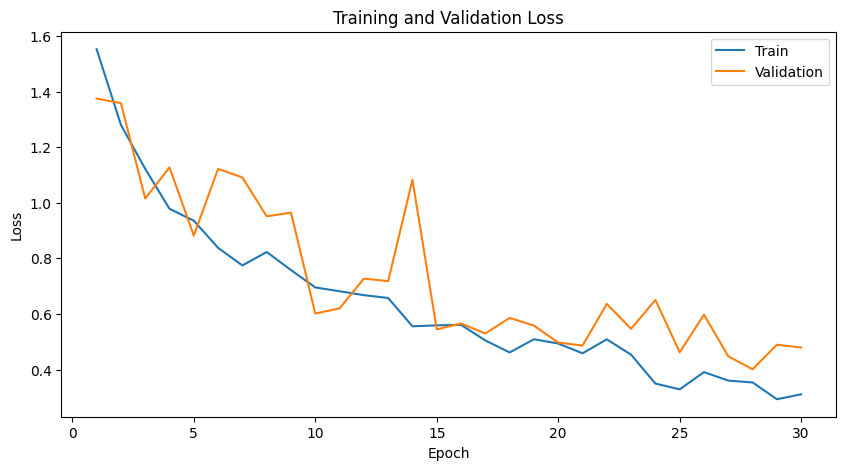

In [14]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

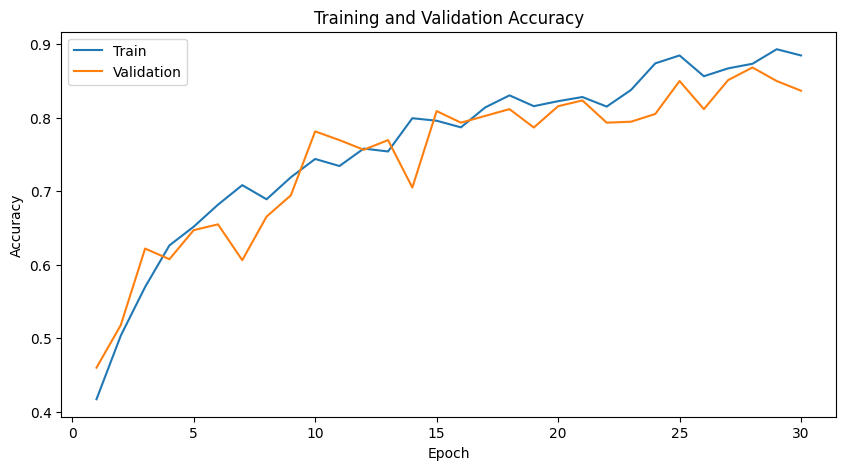

In [15]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in train_accuracies], label='Train')
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in val_accuracies], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

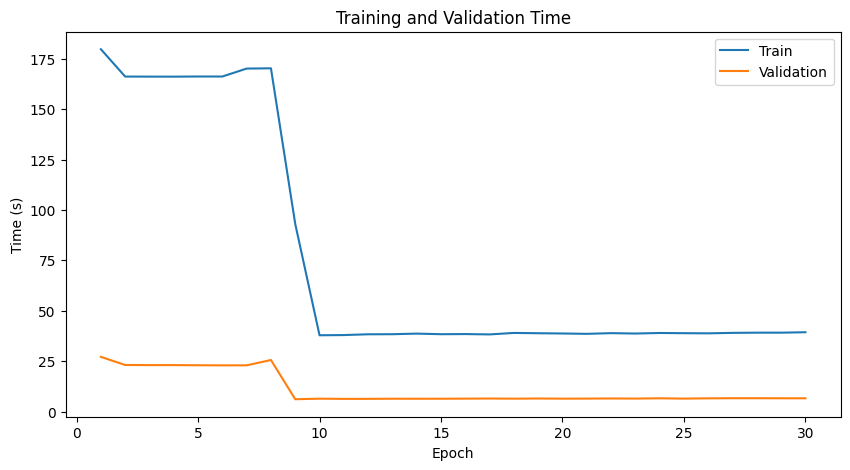

In [16]:
# Plot training and validation times
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_times, label='Train')
plt.plot(range(1, num_epochs + 1), val_times, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Training and Validation Time')
plt.legend()
plt.show()

# MobileNet V2

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.6, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

training_dataset = datasets.ImageFolder('train', transform=transform_train)
validation_dataset = datasets.ImageFolder('val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [4]:
def im_convert(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array(std) + np.array(mean)
    image = image.clip(0, 1)
    return image

In [5]:
classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

In [6]:
# # Load pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\A1\archive\Jupyter\envs\mygpu\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# # Modify the final fully connected layer for your 6 classes
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = torch.nn.Linear(num_ftrs, 6)

In [8]:
# Move the model to the GPU
model = model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [10]:
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    start_time = time.time()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels.data)
    
    end_time = time.time()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_preds.double() / len(train_loader.dataset)
    epoch_time = end_time - start_time
    return epoch_loss, epoch_acc, epoch_time

In [11]:
def validate(model, criterion, val_loader, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) 
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
    
    end_time = time.time()
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct_preds.double() / len(val_loader.dataset)
    epoch_time = end_time - start_time
    return epoch_loss, epoch_acc, epoch_time

In [12]:
# Define lists to store loss and accuracy values for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train_times = []
val_times = []
best_val_acc = 0.0

# Train and validate the model
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc, train_time = train(model, criterion, optimizer, training_loader, device)
    val_loss, val_acc, val_time = validate(model, criterion, validation_loader, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_times.append(train_time)
    val_times.append(val_time)
    
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, "
          f"Train Time: {train_time:.2f}s, Validation Time: {val_time:.2f}s")

Epoch 1/30: Train Loss: 0.9689, Train Accuracy: 0.6544, Validation Loss: 1.6106, Validation Accuracy: 0.5916, Train Time: 79.23s, Validation Time: 11.56s
Epoch 2/30: Train Loss: 0.6390, Train Accuracy: 0.7647, Validation Loss: 0.6508, Validation Accuracy: 0.7826, Train Time: 69.62s, Validation Time: 6.17s
Epoch 3/30: Train Loss: 0.4906, Train Accuracy: 0.8320, Validation Loss: 0.7786, Validation Accuracy: 0.7497, Train Time: 68.73s, Validation Time: 5.84s
Epoch 4/30: Train Loss: 0.4401, Train Accuracy: 0.8445, Validation Loss: 0.4006, Validation Accuracy: 0.8656, Train Time: 69.01s, Validation Time: 6.26s
Epoch 5/30: Train Loss: 0.3525, Train Accuracy: 0.8722, Validation Loss: 0.4012, Validation Accuracy: 0.8775, Train Time: 69.51s, Validation Time: 5.88s
Epoch 6/30: Train Loss: 0.2962, Train Accuracy: 0.9005, Validation Loss: 0.5591, Validation Accuracy: 0.8445, Train Time: 68.62s, Validation Time: 5.98s
Epoch 7/30: Train Loss: 0.3218, Train Accuracy: 0.8908, Validation Loss: 0.4368, 

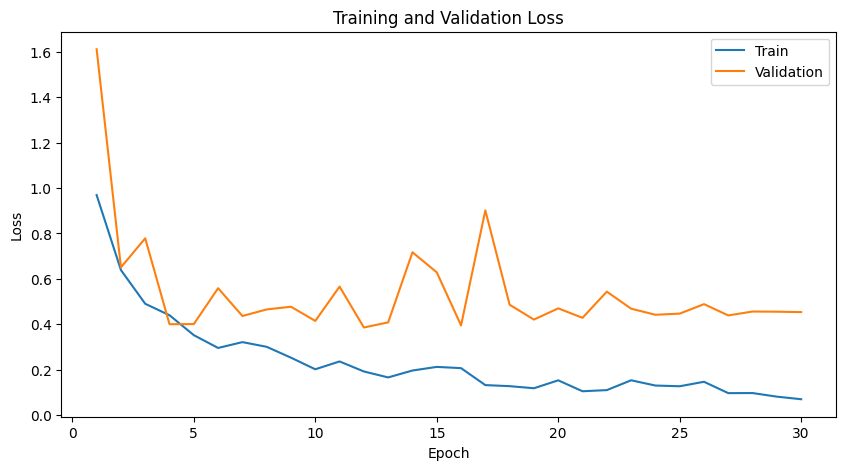

In [13]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

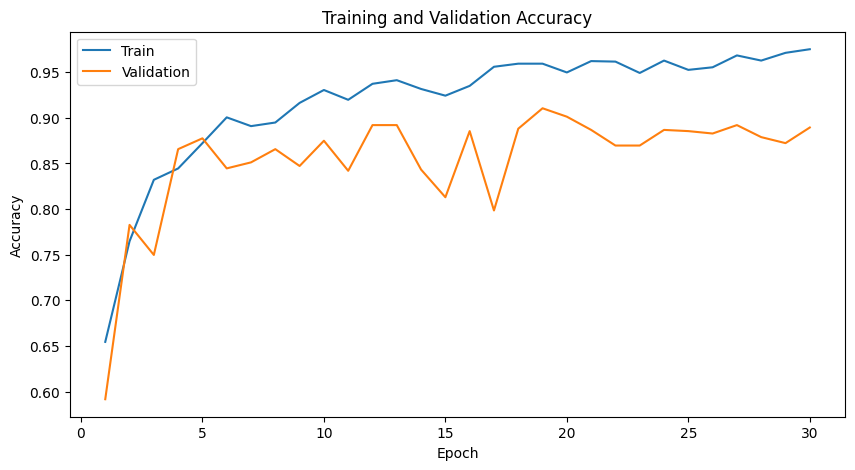

In [14]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in train_accuracies], label='Train')
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in val_accuracies], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

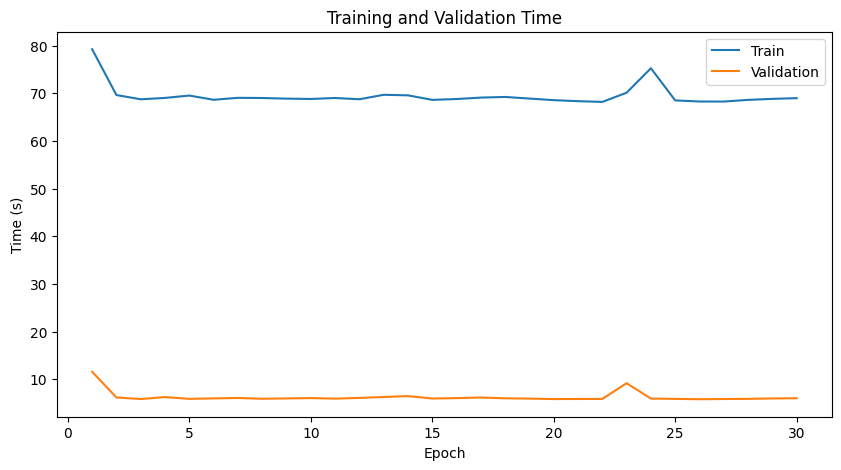

In [15]:
# Plot training and validation times
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_times, label='Train')
plt.plot(range(1, num_epochs + 1), val_times, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Training and Validation Time')
plt.legend()
plt.show()